In [1]:
import math,csv, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf
import scipy.integrate as integrate
import pylab as P
from scipy.optimize import minimize
from collections import Counter
from numpy import linalg as LA
from scipy.stats import norm
from scipy.interpolate import interp1d

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
mu_array = np.linspace(1,3,12)
q = 0.25

In [16]:
def W_empirical(x):
    global W_emp
    return W_emp[np.array(x*10000, dtype='int')]

def W_Bhq(x):
    return np.ones_like(x)

def W_10(x):
    return np.maximum(1 - 10*x,0.5)

def W_quad_1(x):
    return np.maximum(-5*x*x+2.5*x+0.6,0)

def Bh_q_random(pvals, q, W):
    n                  = pvals.shape[0]
    sort_order         = np.argsort(pvals)
    p_vals_sorted      = pvals[sort_order]
    sampling_int       = np.array( np.random.random(size=n) < W(p_vals_sorted), dtype='int')
    for i in np.arange(n-1,-1,-1):
        LHS, _ = integrate.quad(lambda x: W(x), 0, p_vals_sorted[i])
        RHS    = np.sum(sampling_int[:i])*float(q)/float(n)
        if LHS < RHS:
            break
    Rejected     = np.array([False]*n)
    Rejected[:i] = True
    Rejected[np.where(sampling_int==0)] = False

    reverse_sort_order = np.argsort(sort_order)
    return Rejected[reverse_sort_order], p_vals_sorted[i], sampling_int,i


def Bh_q_gibbs(pvals, q, W):
    n                  = pvals.shape[0]
    sort_order         = np.argsort(pvals)
    p_vals_sorted      = pvals[sort_order]
    sampling_int       = np.array( np.random.random(size=n) < W(p_vals_sorted), dtype='int')
    for i in np.arange(n-1,-1,-1):
        LHS    = W_empirical_int(p_vals_sorted[i])
        RHS    = np.sum(sampling_int[:i])*float(q)/float(n)
    Rejected     = np.array([False]*n)
    Rejected[:i] = True
    Rejected[np.where(sampling_int==0)] = False

    reverse_sort_order = np.argsort(sort_order)
    return Rejected[reverse_sort_order], p_vals_sorted[i], sampling_int,i

def plot_ratio(F1, F2, name):
    global mu_array
    plt.figure(figsize=(5,5))
    plt.plot(mu_array, F1/F2)
    plt.title("ratio of powers of fdr_with_random/random_then_fdr for function " + name)
    plt.xlabel("mu")
    plt.ylabel("ratio")
    plt.show()
    

def generate_data(n,n0,mu):
    global W_emp
    gibbs_y, gibbs_x = np.histogram(1 - norm.cdf(np.random.normal(mu,1, size = 200000), 0, 1), bins=2000, normed=True)
    gibbs_x         = (gibbs_x[1:]+gibbs_x[:-1])/2
    gibbs_x[0]      = 0
    gibbs_y         = np.minimum(gibbs_y,1)
    W_emp           = np.interp(np.linspace(0,1,10001), gibbs_x, gibbs_y)
    null_pvals      = np.random.uniform(size=n0) # Null p values
    all_vals        = np.zeros(n)
    alternate_obs   = np.random.normal(mu,1, size = n-n0)
    all_vals[n0:n]  = alternate_obs
    alternate_pvals = 1 - norm.cdf(alternate_obs, 0, 1)
    all_pvals       = np.append(null_pvals, alternate_pvals)
    return all_pvals, null_pvals, alternate_pvals, all_vals

In [17]:
n = 100
n0 = 80
mu = 5
q = 0.1
W = W_empirical
all_p, null_p, alternate_p, all_vals    = generate_data(n,n0,mu)
a, stopping_pvalue, sampling_int, istar = Bh_q_random(all_p, q, W)
Rejections        = np.where(a==True)[0] #Positions of rejections

FDP               = float(len(np.where(Rejections<n0)[0]))/max(len(Rejections),1)
# Bias
true_p_value      = 1 - norm.cdf(mu, 0, 1)
Estimated_values  = all_vals[Rejections]
print np.mean(np.abs(Estimated_values-mu))
print "FDP", FDP

1.2659891105
FDP 0.0909090909091


In [18]:
def run_experiment(n=200, n0=150, no_exp=30, method = Bh_q_random, q=0.25, W=W_Bhq, name="Bhq", plot=False): 
    global mu_array
    FDR_array     = np.zeros_like(mu_array,dtype='float')
    Power_array   = np.zeros_like(mu_array,dtype='float')
    Stopped_array = np.zeros_like(mu_array,dtype='float')
    Bias_array    = np.zeros_like(mu_array,dtype='float')
    null_p_array      = np.array([])
    alternate_p_array = np.array([])
    for i, mu in enumerate(mu_array):
        for j in range(no_exp):
            all_p, null_p, alternate_p, all_vals    = generate_data(n,n0,mu)
            a, stopping_pvalue, sampling_int, istar = method(all_p, q, W)
            Rejections        = np.where(a==True)[0] #Positions of rejections
            if len(Rejections) == 0:
                continue
            FDP               = float(len(np.where(Rejections<n0)[0]))/max(len(Rejections),1)
            # Bias
            Estimated_values  = all_vals[Rejections]
            Bias_array[i]    += np.mean(np.abs(Estimated_values-mu))
            #FDR
            FDR_array[i]     += FDP
            #Power
            Power_array[i] += float(len(Rejections))/(n-n0)*(1-FDP)
            Stopped_array[i] += stopping_pvalue
            
            #Binning values
            null_p_array         = np.append(null_p_array,null_p)
            alternate_p_array    = np.append(alternate_p_array,alternate_p)

    FDR_array     = FDR_array/no_exp
    Power_array   = Power_array/no_exp
    Stopped_array = Stopped_array/no_exp
    Bias_array    = Bias_array/no_exp
    if plot:
        plt.figure(figsize=(16,8))
        plt.subplot(321)
        plt.plot(mu_array,FDR_array, label="Emprical FDR with "+name)
        plt.ylim(0,q*1.3)
        plt.axhline(q, color = 'red', label="FDR threshold q")
        plt.legend()
        plt.ylabel("FDR")
        plt.xlabel("mu")

        plt.subplot(322)
        plt.plot(mu_array,Power_array, label="Emprical Power for "+name)
        plt.legend()
        plt.ylim(0,1)
        plt.ylabel("Power")
        plt.xlabel("mu")

        plt.subplot(323)
        plt.plot(mu_array,Stopped_array, label="Stoppage time for  "+name)
        plt.ylim(0,1.1)
        plt.legend()
        plt.ylabel("Stoppage p value")
        plt.xlabel("mu")

        plt.subplot(324)
        x = np.arange(0,1,0.1)
        plt.xlabel("p _value")
        plt.ylabel("rejection probability")
        plt.ylim(0,1.1)
        plt.title("rejection curve W(x)")
        plt.axvline(np.mean(Stopped_array),color="red")
        plt.plot(x,W(x))

        plt.subplot(325)
        plt.plot(mu_array,Bias_array, label="Bias for "+name)
        plt.xlabel("mu")
        plt.ylabel("absolute bias")
        plt.title("Bias")
        
        
        plt.subplot(326)
        plt.hist(null_p_array, color="black", label="null values", bins = 50,normed=True)
        plt.hist(alternate_p_array, color="blue", label="alternate values", bins = 50, normed=True)
        plt.xlabel("x")
        plt.ylabel("p(x)")
        plt.title("data")
        plt.legend()
        
        
        plt.show()
    return FDR_array, Power_array, Stopped_array, Bias_array

In [26]:
FDR_array_Emp, Power_array_Emp, Stopped_array_Emp, Bias_array_Emp = run_experiment(n=200, n0=150, no_exp=100,
                                                                   q=q, W=W_empirical, name="Bhq", plot=True)

KeyboardInterrupt: 

In [ ]:
FDR_array_Bhq, Power_array_Bhq, Stopped_array_Bhq, Bias_array_Bhq = run_experiment(n=200, n0=150, no_exp=100,
                                                             q=q, W=W_Bhq, name="Bhq", plot=True)

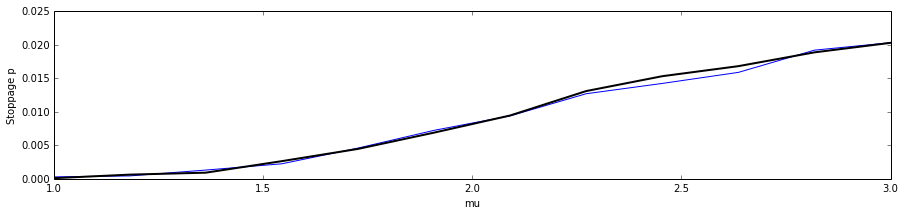

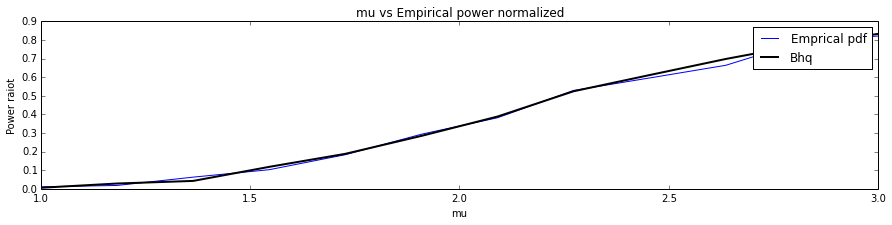

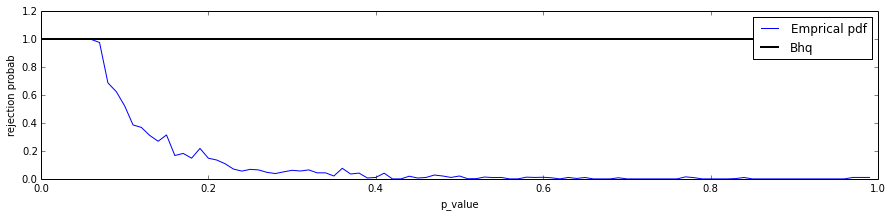

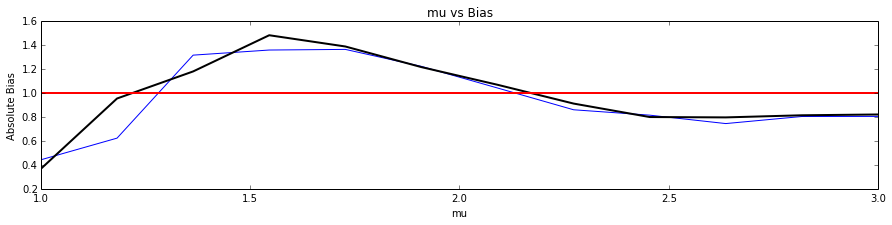

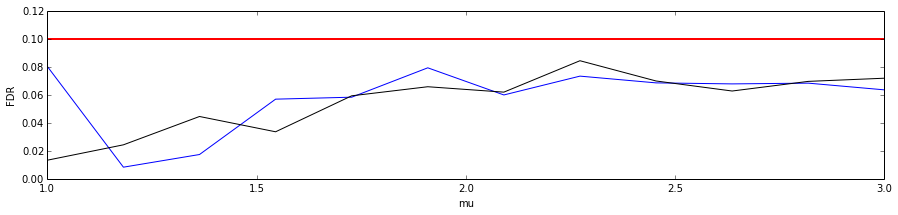

In [25]:


plt.figure(figsize=(15,3))

plt.plot(mu_array,Stopped_array_Emp, label="Emprical pdf")
plt.plot(mu_array,Stopped_array_Bhq, color="black",  linewidth=2, label="Emprical stoppage Bhq" )
# plt.legend()
plt.ylabel("Stoppage p")
plt.xlabel("mu")


plt.figure(figsize=(15,3))
plt.plot(mu_array,Power_array_Emp, label="Emprical pdf")
plt.plot(mu_array,Power_array_Bhq, color="black", linewidth=2, label="Bhq" )
plt.legend()
plt.ylabel("Power raiot")
plt.title("mu vs Empirical power normalized")
plt.xlabel("mu")


x = np.arange(0,1,0.01)
plt.figure(figsize=(15,3))
plt.plot(x,W_empirical(x), label="Emprical pdf")
plt.plot(x,W_Bhq(x), color="black",  linewidth=2, label="Bhq" )
plt.xlabel("p_value")
plt.ylabel("rejection probab")
plt.ylim(0,1.2)
plt.legend()
plt.plot()

plt.figure(figsize=(15,3))
plt.plot(mu_array, Bias_array_Emp,    label="W_2_5")
plt.plot(mu_array, Bias_array_Bhq, linewidth=2,      color="black", label="Bhq" )
plt.axhline(1, color = 'red',  linewidth=2, label="W_1 threshold q")

plt.ylabel("Absolute Bias")
plt.title("mu vs Bias")
plt.xlabel("mu")
plt.figure(figsize=(15,3))
plt.plot(mu_array,FDR_array_Emp, label="Emprical pdf")
plt.plot(mu_array,FDR_array_Bhq, color="black", label="Emprical FDR Bhq")
plt.ylim(0,q*1.2)
plt.axhline(q, color = 'red',  linewidth=2, label="W_1 threshold q")
# plt.legend()
plt.ylabel("FDR")
plt.xlabel("mu")
plt.show()

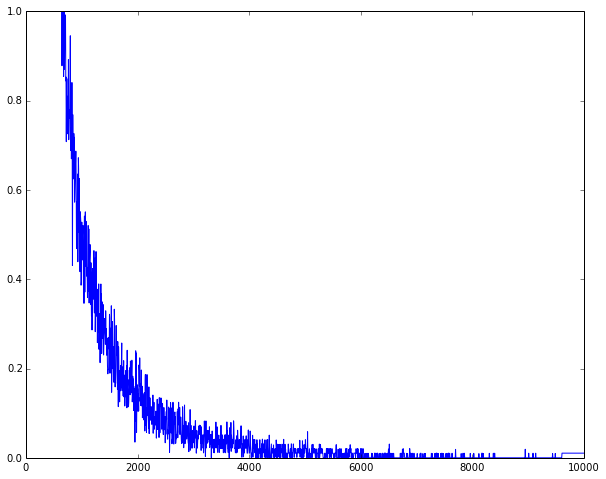

In [22]:
plt.plot(W_emp, label="Emprical pdf")


In [ ]:
mu = 5
gibbs_y, gibbs_x = np.histogram(1 - norm.cdf(np.random.normal(mu,1, size = 200000), 0, 1), bins=100, normed=True)
gibbs_x         = (gibbs_x[1:]+gibbs_x[:-1])/2
gibbs_x[0]      = 0
gibbs_y         = np.minimum(gibbs_y,1)
W_emp           = np.interp(np.linspace(0,1,10001), gibbs_x, gibbs_y)

In [ ]:
gibbs_y, gibbs_x = np.histogram(1 - norm.cdf(np.random.normal(mu,1, size = 200000), 0, 1), bins=100, normed=True)
gibbs_x         = (gibbs_x[1:]+gibbs_x[:-1])/2
gibbs_y         = np.minimum(gibbs_y,1)


In [ ]:
print gibbs_y
print gibbs_x

In [ ]:
W_emp = np.interp(np.linspace(0,1,10001), gibbs_x, gibbs_y)

In [ ]:
W_emp

In [ ]:
plt.plot(W_emp)